In [1]:
import requests
from bs4 import BeautifulSoup as soup
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import csv
import pandas as pd
import numpy as np
import re

In [2]:
def scrape_covid_data(page):

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                         '(KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36 Edg/86.0.622.51'}
    url = f'https://muriae.mg.gov.br/{page}/'

    request = requests.get(url, headers=headers)
    page_soup = soup(request.content, 'html.parser')
    conteudo = page_soup.body.div.text.replace('\xa0', '').split('Números completos de ')

    for n, bol in enumerate(conteudo[1:]): #elemento 0 não é boletim
    
        exclude_end = re.search('\n\n\n\n\n\n\n\n', bol).span()[0]
        conteudo[n] = bol[:exclude_end]
        conteudo[n] = conteudo[n].split()

        for pos, word in enumerate(conteudo[n]): #separa dados dos campos
            word = word.replace('.', '')
            for v, letter in enumerate(word):
                if letter.isnumeric()==False and word[v-1].isnumeric()==True and letter !=  ':':    
                    conteudo[n][pos] = word[:v]
                    conteudo[n][pos+1] = word[v:] + ' ' + conteudo[n][pos+1]
                else:
                    continue
    
    for n, bol in enumerate(conteudo[:-1]):
        for pos, word in enumerate(bol):
            count = 0
            if word.isupper()==True:
                bol.remove(word)
            else:
                for letter in word:
                    if letter.isupper()==True:
                        count += 1
                    else:
                        if count > 2:
                            conteudo[n][pos] = word[count-1:]
    i = 1
    for n, bol in enumerate(conteudo[:-1]):
        for pos, word in enumerate(bol):
            col = word
            if word[-1]==':':
                while bol[pos-i].replace(' ', '').isalpha():
                    bol[pos] = bol[pos-i] + ' ' + bol[pos]
                    i += 1
                else:
                    i = 1
    
    collection = [] #arrolar campos (palavra contem dois-pontos)
    doc = {}

    for bol in conteudo[:-1]: 
        for word in bol:
            doc['data:'] = bol[0] + bol[1][:5]
            if word[-1] == ':':
                index = bol.index(word)
                doc[word] = bol[index+1]
            else:
                pass
        collection.append(doc)
        doc = {}
    
    df = pd.DataFrame([i for i in reversed(collection)]).drop(['HOJENovos casos:',
                                                               'Novos óbitos:'], axis=1)
    df = df[['data:', '/2022:VACINAS APLICADASDose 1:',
             'Dose 2:','Reforço 1:', 'PANDEMIATotal de casos:', 'Pacientes ativos:',
             'Total de óbitos:', 'Reforço 2:', 'Dose Adicional (imunossuprimidos):']]
    df.rename(columns={'data:':'Data', '/2022:VACINAS APLICADASDose 1:':'Dose 1',
                       'Dose 2:':'Dose 2', 'Reforço 1:':'Dose 3',
                       'PANDEMIATotal de casos:':'Casos Totais', 
                       'Pacientes ativos:':'Casos Ativos',
                       'Total de óbitos:':'Óbitos'}, inplace=True)
                                                              
    return df

In [3]:
def data_retype(df):
    df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)
    
    return df[::-1]

In [4]:
#a prefeitura remove os boletins depois de algum tempo, é necessário usar um backup
def backup_concat(df):
    bkup = pd.read_csv('covid-muriae-auto.csv', sep=';', encoding='latin1').drop(['Casos Diários',
                                                                                 'Óbitos Diários'], axis=1)
    
    bkup['Data'] = [pd.to_datetime(data, format='%Y-%m-%d') for data in bkup['Data']]
    #filtra os registros do backup que já estão no df oriundo de scrape
    bkup = bkup.loc[[data not in df['Data'].values for data in bkup['Data']]]
    bkup.reset_index(drop=True, inplace=True)
    
    #dataframe ainda faltando dias não letivos
    df = pd.concat([bkup, df[::-1]], axis=0)
    df['Dose 3'] = df['Dose 3'].fillna(0).astype(int)
    
    df.reset_index(drop=True, inplace=True)
    
    inicio, hoje = df.Data.min(), df.Data.max()
    intervalo = pd.date_range(inicio, hoje)
    d2 = {'Data': intervalo}
    df2 = pd.DataFrame(data=d2)
    df = pd.merge(df2, df, on='Data', how='left')
    df.fillna(method='ffill', inplace=True)
    df['Casos Diários'] = df['Casos Totais'].diff().fillna(0).astype(int)
    df['Óbitos Diários'] = df['Óbitos'].astype(int).diff().fillna(0).astype(int)
    df.fillna(0, inplace=True)
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)
    
    return df

In [5]:
df = scrape_covid_data(page='coronavirus').pipe(data_retype).pipe(backup_concat)

In [6]:
def plotar_casosVSimun(save=False, show=True):
    from numpy import max
    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.plot(df['Data'], df['Dose 1'], color='#8dae56', linewidth=0.5, label='Dose 1 da Vacina')
    plt.plot(df['Data'], df['Dose 2'], color='green', linewidth=0.5, label='Dose 2 e dose única da Vacina')
    plt.plot(df['Data'], df['Dose 3'], color='#437c3f', linewidth=0.5, label='Dose 3')
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.xticks(df['Data'][::60], fontsize=2, rotation=20, y=0.04)
    plt.xlim(min(df['Data']), max(df['Data']))
    plt.ylim(0, max(df['Dose 1'] + 16000))
    plt.yticks(range(0, max(df['Dose 1']), 6000), fontsize=3, x=0.03)
    plt.ylabel('Doses', fontsize=2, labelpad=0.8)
    plt.legend(loc='upper right', fontsize=2)
    
    ax2 = plt.gca().twinx()
    plt.ylabel('Casos Ativos', fontsize=2, labelpad=0.8)
    plt.yticks(fontsize=2)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.ylim(0, max(df['Casos Ativos'] + 20))
    plt.plot(df['Data'], df['Casos Ativos'], color='orange', linewidth=0.5, label='Casos ativos')
    plt.title('Casos Ativos vs Doses aplicadas em Muriaé \n'
              'segundo os boletins epidemiológicos da \n'
              'Prefeitura de Muriaé', fontsize=2.5, y=0.96)
    
    plt.tight_layout()
    if save:
        
        plt.savefig('Gráficos/ativos-vs-imunizados.png')
        
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_casosAtivos(save=False, show=True):
    from numpy import max, min

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.plot(df['Data'], df['Casos Ativos'], color='orange', linewidth=0.5)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.ylim(0, max(df['Casos Ativos']+20))
    plt.yticks(range(0, max(df['Casos Ativos']), 45), fontsize=3, x=0.03)
    plt.xticks(df['Data'][::60], fontsize=2.5, rotation=20, y=0.04)
    plt.ylabel('Casos Ativos', fontsize=6, labelpad=0.47)
    plt.title(
        'Evolução dos Casos Ativos de COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n da '
        'Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('Gráficos/casos_ativos.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_obitos(save=False, show=True):
    from numpy import max

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(df['Data'], df['Óbitos Diários'], color='red', width=1)
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(df['Óbitos Diários']) + 1), fontsize=3, x=0.02)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.xticks(df['Data'][::90], fontsize=2.5, rotation=20, y=0.04)
    plt.ylabel('Óbitos Diários', fontsize=6, labelpad=0.48)
    plt.title(
        'Óbitos diários por COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n '
        'da Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('Gráficos/covid_obitos.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_casos_diarios(save=False, show=True):
    from numpy import max

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(df['Data'], df['Casos Diários'], color='blue')
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(df['Casos Diários']), 20), fontsize=3, x=0.02)
    plt.xticks(df['Data'][::60], fontsize=2.5, rotation=20, y=0.04)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.ylim(0)
    plt.ylabel('Casos Diários', fontsize=6, labelpad=0.48)
    plt.title(
        'Casos Diários de COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n da '
        'Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('Gráficos/casos_diarios.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass

def relacao_ativosObtos(save=False, show=True):
    
    plt.figure(figsize=(13,12))
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(df['Data'], df['Óbitos Diários'], color='red')
    plt.ylabel('Óbitos diários', fontsize=16)
    plt.yticks(fontsize=14)
    ax2 = plt.gca().twinx()
    plt.ylabel('Casos Ativos', fontsize=16)
    plt.yticks(fontsize=14)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.plot(df['Data'], df['Casos Ativos'], color='blue')
    plt.ylim(0)
    plt.title(
            'Casos Ativos vs óbitos por COVID-19 em Muriaé \n '
            'segundo os boletins epidemiológicos \n da '
            'Prefeitura de Muriaé'
        )
    if save:
        plt.savefig('Gráficos/casos_obitos.png')
    else:
        pass

    if show:
        plt.show()
    else:
        pass
    

In [7]:
#df.to_csv('covid-muriae.csv', encoding='latin1', sep=';', index=False)

In [8]:
pd.set_option('display.max_rows', None)

In [9]:
plt.rcParams.update({'figure.facecolor': '#92b69e'})
plt.rcParams['axes.linewidth'] = 0.1

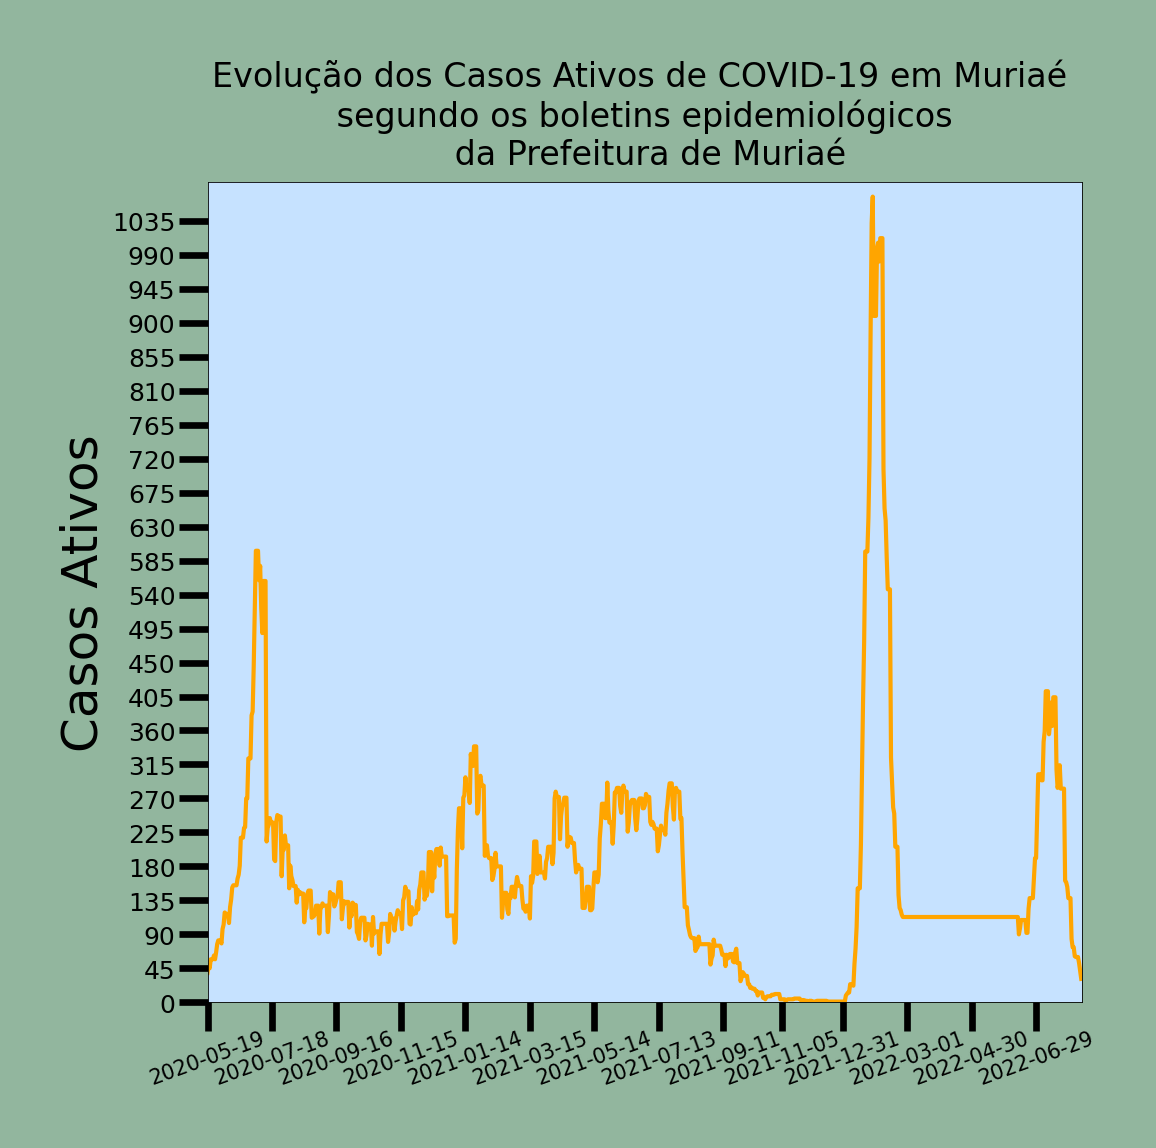

In [10]:
plotar_casosAtivos(save=False)

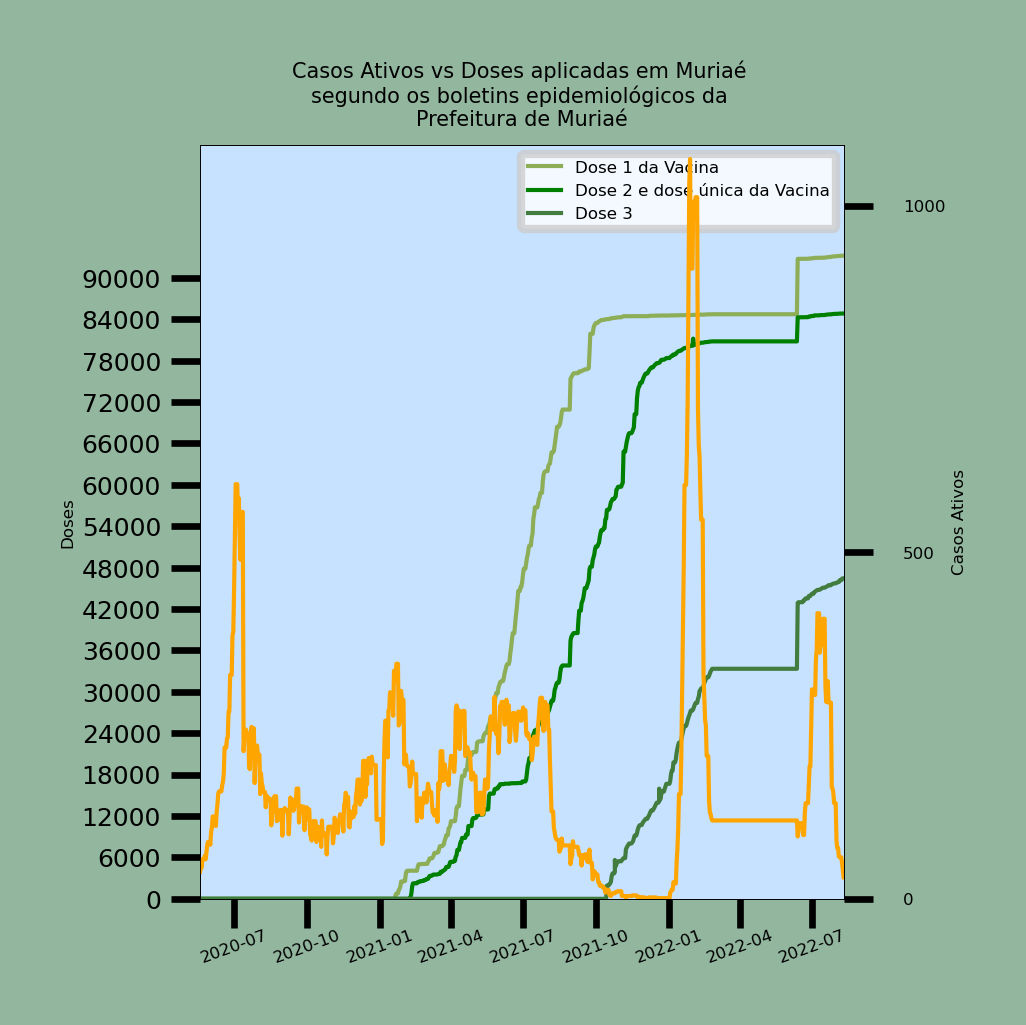

In [11]:
plotar_casosVSimun(save=False)

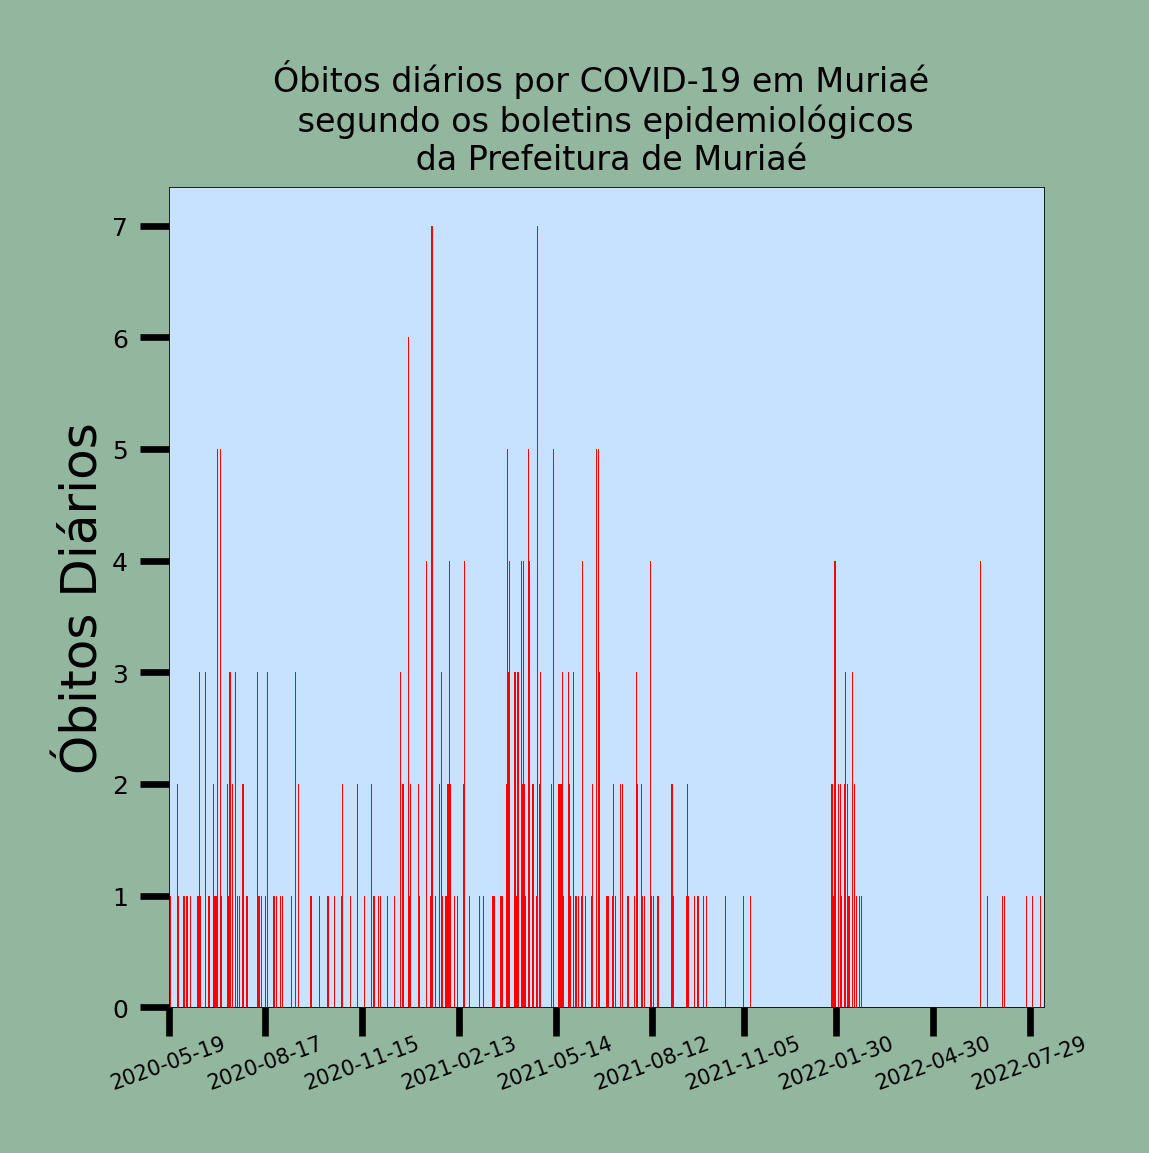

In [12]:
plotar_obitos(save=False)

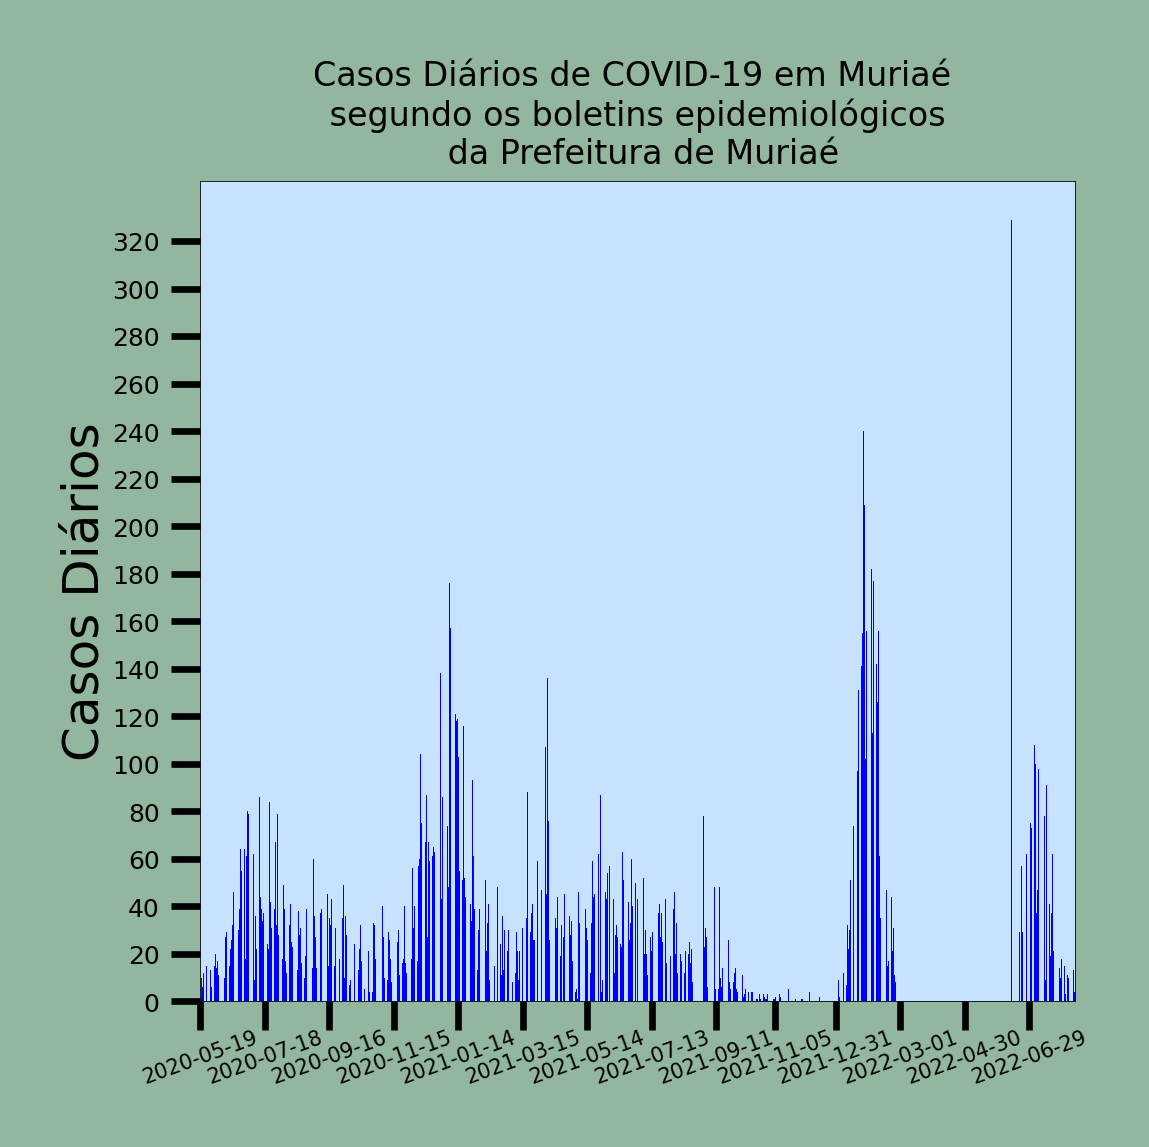

In [13]:
plotar_casos_diarios(save=False)

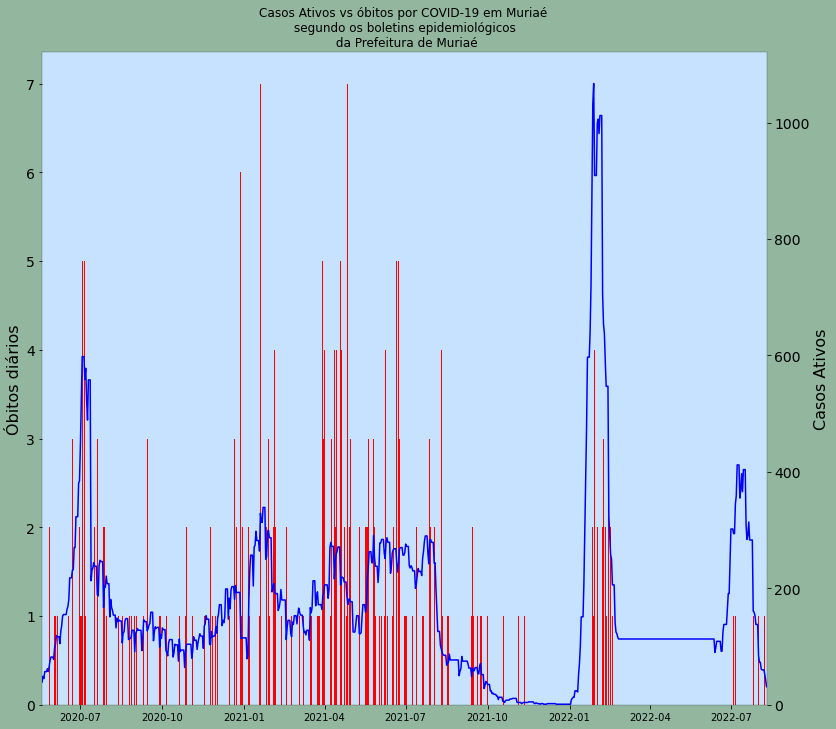

In [14]:
relacao_ativosObtos(save=False)